In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


# Train

In [7]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [8]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [9]:
from tensorflow import keras

* Embedidng 같이, NC LSTM, Miss LSTM 따로 modeling

* [Peptide Transformer embedding, (concat) cleavage site 15-mer LSTM output] -> object function binary crossentropy !! 

In [33]:
pep = tf.keras.layers.Input(shape=((30,)))
input1_ = tf.keras.layers.Embedding(21, 128, input_length=30, mask_zero=True)(pep)
input1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.5))(input1_)

input2 = tf.keras.layers.Input(shape=((39,)))  # peptide info

ts_emb = tf.keras.layers.Embedding(21, 64, input_length=15, mask_zero=True)

n = tf.keras.layers.Input(shape=((15,)))
input3_ = ts_emb(n)
input3 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(input3_)

c = tf.keras.layers.Input(shape=((15,)))
input4_ = ts_emb(c)
input4 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(input4_)

m1 = tf.keras.layers.Input(shape=((15,)))
input5_ = ts_emb(m1)
input5 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(input5_)

m2 = tf.keras.layers.Input(shape=((15,)))
input6_ = ts_emb(m2)
input6 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(input6_)



# reshap1 = keras.backend.reshape(input1, [-1, 30, 128, 1])
# cnn1 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Conv1D(
#         filters=32, kernel_size=2, strides=1, padding='same')
#     )(reshap1)
# avgpool1 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.AveragePooling1D(pool_size=2)
#     )(cnn1)
# flat1 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Flatten()
#     )(avgpool1)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(input1)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm1)
net_lstm_ = tf.keras.layers.Dense(32, activation='relu')(lstm1)
net_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.5))(net_lstm_)

net_dense1_ = tf.keras.layers.Dense(32, activation='relu')(input2)
net_dense1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(net_dense1_)


ts_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))
ts_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))

# reshap3 = keras.backend.reshape(input3, [-1, 15, 64, 1])
# cnn3 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Conv1D(
#         filters=16, kernel_size=2, strides=1, padding='same')
#     )(reshap3)
# avgpool3 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.AveragePooling1D(pool_size=2)
#     )(cnn3)
# flat3 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Flatten()
#     )(avgpool3)

digest_n = ts_lstm1(input3)
digest_n = ts_lstm2(digest_n)
net_n_ = tf.keras.layers.Dense(16, activation='relu')(digest_n)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(net_n_)

# reshap4 = keras.backend.reshape(input4, [-1, 15, 64, 1])
# cnn4 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Conv1D(
#         filters=16, kernel_size=2, strides=1, padding='same')
#     )(reshap4)
# avgpool4 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.AveragePooling1D(pool_size=2)
#     )(cnn4)
# flat4 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Flatten()
#     )(avgpool4)
digest_c = ts_lstm1(input4)
digest_c = ts_lstm2(digest_c)
net_c_ = tf.keras.layers.Dense(16, activation='relu')(digest_c)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(net_c_)

miss_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))
miss_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))

# reshap5 = keras.backend.reshape(input5, [-1, 15, 64, 1])
# cnn5 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Conv1D(
#         filters=16, kernel_size=2, strides=1, padding='same')
#     )(reshap5)
# avgpool5 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.AveragePooling1D(pool_size=2)
#     )(cnn5)
# flat5 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Flatten()
#     )(avgpool5)
digest_m1 = miss_lstm1(input5)
digest_m1 = miss_lstm2(digest_m1)
net_m1_ = tf.keras.layers.Dense(16, activation='relu')(digest_m1)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(net_m1_)

# reshap6 = keras.backend.reshape(input6, [-1, 15, 64, 1])
# cnn6 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Conv1D(
#         filters=16, kernel_size=2, strides=1, padding='same')
#     )(reshap6)
# avgpool6 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.AveragePooling1D(pool_size=2)
#     )(cnn6)
# flat6 = tf.keras.layers.TimeDistributed(
#     tf.keras.layers.Flatten()
#     )(avgpool6)
digest_m2 = miss_lstm1(input6)
digest_m2 = miss_lstm2(digest_m2)
net_m2_ = tf.keras.layers.Dense(16, activation='relu')(digest_m2)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))(net_m2_)




merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                     net_n,
                                     net_c,
                                     net_m1,
                                     net_m2])

net1 = tf.keras.layers.Dense(64, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.5))(net1)
net3 = tf.keras.layers.Dense(32, activation='relu')(net1_drop)
net3_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.5))(net3)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3_drop)

model_high = tf.keras.Model(inputs=[pep, input2,
                              n, c,
                              m1, m2],
                       outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(3e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_69 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 15)]         0                                            
___________________________________________________________________________________________

In [34]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=512,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
1062/1062 [==============================] - 366s 282ms/step - loss: 4.5256 - accuracy: 0.5174 - val_loss: 0.6758 - val_accuracy: 0.6840
Epoch 2/300
1062/1062 [==============================] - 274s 258ms/step - loss: 0.6437 - accuracy: 0.6401 - val_loss: 0.5008 - val_accuracy: 0.7630
Epoch 3/300
1062/1062 [==============================] - 273s 257ms/step - loss: 0.5160 - accuracy: 0.7548 - val_loss: 0.4603 - val_accuracy: 0.7848
Epoch 4/300
1062/1062 [==============================] - 273s 257ms/step - loss: 0.4775 - accuracy: 0.7790 - val_loss: 0.4463 - val_accuracy: 0.7929
Epoch 5/300
1062/1062 [==============================] - 274s 258ms/step - loss: 0.4594 - accuracy: 0.7908 - val_loss: 0.4334 - val_accuracy: 0.8005
Epoch 6/300
1062/1062 [==============================] - 274s 258ms/step - loss: 0.4458 - accuracy: 0.7975 - val_loss: 0.4261 - val_accuracy: 0.8056
Epoch 7/300
1062/1062 [==============================] - 274s 258ms/step - loss: 0.4364 - accuracy: 0.8019

Epoch 56/300
1062/1062 [==============================] - 218s 206ms/step - loss: 0.3566 - accuracy: 0.8422 - val_loss: 0.3735 - val_accuracy: 0.8338
Epoch 57/300
1062/1062 [==============================] - 227s 214ms/step - loss: 0.3539 - accuracy: 0.8438 - val_loss: 0.3734 - val_accuracy: 0.8339
Epoch 58/300
1062/1062 [==============================] - 220s 207ms/step - loss: 0.3533 - accuracy: 0.8443 - val_loss: 0.3724 - val_accuracy: 0.8339
Epoch 59/300
1062/1062 [==============================] - 224s 211ms/step - loss: 0.3519 - accuracy: 0.8447 - val_loss: 0.3726 - val_accuracy: 0.8339
Epoch 60/300
1062/1062 [==============================] - 223s 210ms/step - loss: 0.3516 - accuracy: 0.8454 - val_loss: 0.3719 - val_accuracy: 0.8347
Epoch 61/300
1062/1062 [==============================] - 222s 209ms/step - loss: 0.3524 - accuracy: 0.8453 - val_loss: 0.3723 - val_accuracy: 0.8345
Epoch 62/300
1062/1062 [==============================] - 220s 207ms/step - loss: 0.3514 - accuracy:

1062/1062 [==============================] - 225s 212ms/step - loss: 0.3061 - accuracy: 0.8697 - val_loss: 0.3892 - val_accuracy: 0.8306
Epoch 111/300
1062/1062 [==============================] - 223s 210ms/step - loss: 0.3048 - accuracy: 0.8707 - val_loss: 0.3876 - val_accuracy: 0.8307
Epoch 112/300
1062/1062 [==============================] - 228s 214ms/step - loss: 0.3040 - accuracy: 0.8707 - val_loss: 0.3886 - val_accuracy: 0.8305
Epoch 113/300
1062/1062 [==============================] - 216s 203ms/step - loss: 0.3026 - accuracy: 0.8721 - val_loss: 0.3893 - val_accuracy: 0.8298
Epoch 114/300
1062/1062 [==============================] - 224s 211ms/step - loss: 0.3022 - accuracy: 0.8706 - val_loss: 0.3890 - val_accuracy: 0.8284
Epoch 115/300
1062/1062 [==============================] - 221s 208ms/step - loss: 0.3024 - accuracy: 0.8718 - val_loss: 0.3907 - val_accuracy: 0.8294
Epoch 116/300
1062/1062 [==============================] - 224s 211ms/step - loss: 0.3010 - accuracy: 0.8726

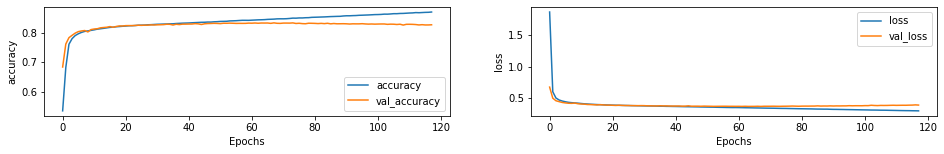

In [35]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

4188/4188 [==============================] - 134s 32ms/step - loss: 0.3960 - accuracy: 0.8264
Test Loss: 0.39595481753349304
Test Accuracy: 0.826400101184845
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     66996
           1       0.80      0.88      0.83     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992

rf auc : 0.9090540083322793


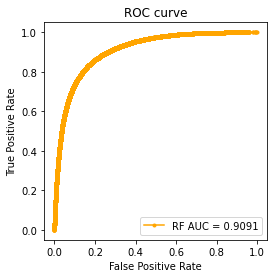

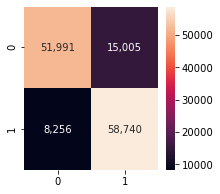

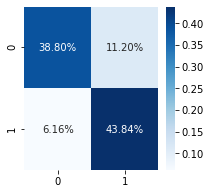

In [36]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()